In [1]:
import json
import pandas as pd

data = [json.loads(line) for line in open('../data/Ferrara2023-citizens-individualChallenges.json')]
data = [d for d in data if d['concept']['modelName'] != 'survey' and d['concept']['state'] in ['COMPLETED', 'FAILED']]
filtered_data = [
    {
        'user_id': d['playerId'],
        'counter': d['concept']['fields']['counterName'],
        'target': int(d['concept']['fields']['target']),
        'periodTarget': d['concept']['fields']['periodTarget'],
        'start': d['concept']['start'],
        'completed': int(d['concept']['completed']),
    }
    for d in data
]

df = pd.DataFrame(filtered_data)
df['start'] = pd.to_datetime(df['start'])
df['periodTarget'] = df['periodTarget'].fillna(1).astype(int)
df['item_id'] = df['counter'] + '/' + df['target'].astype(str) + '/' + df['periodTarget'].astype(str)
df = df[df['start'] < '2023-09-17']

df.sort_values('start', ascending=True, inplace=True, ignore_index=True)

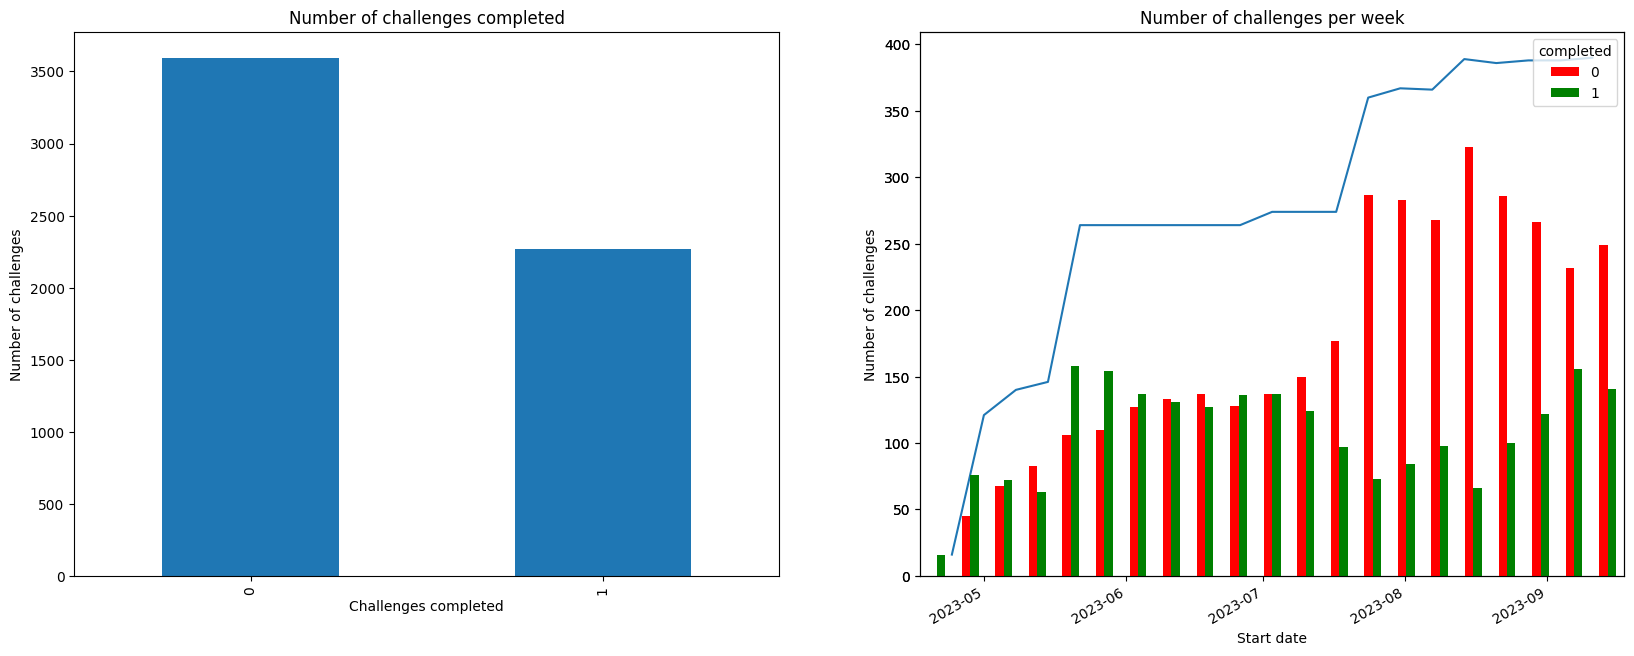

In [2]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

df['completed'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Number of challenges completed')
ax1.set_xlabel('Challenges completed')
ax1.set_ylabel('Number of challenges')

df.groupby('start').size().plot(ax=ax2)
ax3 = ax2.twiny()
df.groupby(['start', 'completed']).size().unstack().plot(ax=ax3, legend=True, stacked=False, kind='bar', color=['red', 'green'])
ax3.set_xlabel('')
ax3.set_xticks([])

ax2.set_title('Number of challenges per week')
ax2.set_xlabel('Start date')
ax2.set_ylabel('Number of challenges')

plt.show()

In [ ]:
df